# Training Analysis

In [2]:
import os
import sys
from tqdm import tqdm
import natsort
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import cv2
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from PIL import Image

from data.loader import define_loaders
from utils.utils import load_config
from utils.torch import load_model_weights
from model_zoo.models import define_model
from utils.plot import plot_metrics, plot_training_loss
from data.dataset import Sentinel2Dataset, read_images
from training.metrics import MultiSpectralMetrics
from post_training.post_training import (generate_exp_paths,prepare_paths, prepare_data,
                                         evaluate_and_plot, calculate_valid_pixel_percentages,
                                         plot_3d_scatter)


## Load Config

In [3]:
path = "/home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-05-03_15-47-10"
exp_paths = generate_exp_paths(exp_path=path)
config = load_config(config_path=f"{exp_paths['result_dir']}/config.yaml")

## Training metrics and losses plot

In [4]:
version = config['DATASET']['version']
bands = config['DATASET']['bands']
resize = config['TRAINING']['resize']
num_workers = config['TRAINING']['num_workers']

# df_loss = pd.read_csv(f"{exp_paths['metrics_path']}/losses.csv")
# df_ssim = pd.read_csv(f"{exp_paths['metrics_path']}/ssim_metrics.csv")
# df_sam = pd.read_csv(f"{exp_paths['metrics_path']}/sam_metrics.csv")
# df_rmse = pd.read_csv(f"{exp_paths['metrics_path']}/rmse_metrics.csv")
# df_psnr = pd.read_csv(f"{exp_paths['metrics_path']}/psnr_metrics.csv")

In [ ]:
# Plot all metrics
metrics = {
    "PSNR": df_psnr,
    "SSIM": df_ssim,
    "SAM": df_sam,
    "RMSE": df_rmse
}
for title, df_metric in metrics.items():
    plot_metrics(df_metric, bands=bands, title=f"{title} Evolution During Training - Dataset {version}",
                log_scale=False, y_label=title, verbose=False, save=True,
                save_path=exp_paths['metrics_path'], color_palette="plasma")

In [ ]:
plot_training_loss(df=df_loss,
                title="Training and Validation Loss",
                y_label="Loss",
                log_scale=False,
                verbose=False,
                save=True,
                save_path=exp_paths['metrics_path'],
                color_palette="plasma"
                )

## Create Dataset

In [5]:
# Load test data
test_dir = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_test_input, df_test_output = prepare_paths(test_dir)

In [6]:
# df_test_output = calculate_valid_pixel_percentages(df=df_test_output, column_name="path", show_progress=True)
test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)
test_loader = define_loaders(
    train_dataset=test_dataset,
    val_dataset=None,
    train=False,
    batch_size=1,
    num_workers=num_workers
)

## Load Model 

In [7]:
weights_path = f"{exp_paths['checkpoint_path']}/best_model.pth"
model = define_model(name=config["MODEL"]["model_name"],
                    encoder_name=config["MODEL"]["encoder_name"],
                    in_channel=len(bands),
                    out_channels=len(bands),
                    activation=config["MODEL"]["activation"])

# Load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

2025-05-03 16:30:16.023 | INFO     | utils.torch:load_model_weights:103 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-05-03_15-47-10/checkpoints/best_model.pth



## Test Dataset inference

In [9]:
test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)
metrics_dict = {f"{metric}_{band}": [] for band in test_metrics_tracker.bands for metric in ['psnr', 'rmse', 'ssim', 'sam']}

# Reset tracker and model evaluation
model.eval()
test_metrics_tracker.reset()
criterion = torch.nn.MSELoss()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:
        for x_data, y_data, valid_mask in test_loader:
            x_data, y_data, valid_mask  = x_data.to(device), y_data.to(device), valid_mask.to(device)
            outputs = model(x_data)
            test_metrics_tracker.reset()
            test_metrics_tracker.update(outputs, y_data, valid_mask )
            metrics = test_metrics_tracker.compute()
            for band in test_metrics_tracker.bands:
                for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
                    metrics_dict[f"{metric_name}_{band}"].append(metrics[band][metric_name])

            t.update(x_data.size(0))

# Update DataFrame with metrics
for column_name, values in metrics_dict.items():
    df_test_output[column_name] = values

  0%|                                                                       | 0/530 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 530/530 [01:04<00:00,  8.27it/s]


## Visualize Random Inference data 

In [10]:
random_index = np.random.choice(df_test_input.index)
random_row = df_test_input.loc[random_index]

In [18]:
def evaluate_and_plot(model, df_test_input, df_test_output, bands,cmap,  resize, device, index, verbose, save, output_path):
    """
    Evaluates and plots input, target, prediction, and absolute difference for a specific index.

    Parameters:
        model: Trained model for evaluation.
        df_test_input: DataFrame containing the input data paths.
        df_test_output: DataFrame containing the output data paths.
        bands: List of band names (e.g., ['B02', 'B03', 'B04']) to evaluate.
        resize: The resize dimension for images.
        device: The device (CPU or GPU) to run the model on.
        index: The specific index to evaluate from the data.
    """
    # Load input data and mask
    x_paths = natsort.natsorted(glob.glob(os.path.join(df_test_input["path"][index], "*.png"), recursive=False))
    x_data, x_mask = read_images(x_paths)
    x_data = cv2.resize(x_data, (resize, resize), interpolation=cv2.INTER_AREA)
    x_mask = cv2.resize(x_mask.astype(np.uint8), (resize, resize), interpolation=cv2.INTER_NEAREST).astype(bool)

    # Load output data and mask
    y_paths = natsort.natsorted(glob.glob(os.path.join(df_test_output["path"][index], "*.png"), recursive=False))
    y_data, y_mask = read_images(y_paths)
    y_data = cv2.resize(y_data, (resize, resize), interpolation=cv2.INTER_AREA)
    y_mask = cv2.resize(y_mask.astype(np.uint8), (resize, resize), interpolation=cv2.INTER_NEAREST).astype(bool)

    # Combine masks: valid only where both input and target are valid
    valid_mask = x_mask & y_mask  # Shape: H x W x C

    # Prepare tensors for inference
    x_tensor = torch.from_numpy(x_data).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, C, H, W]

    # Inference
    model.eval()
    with torch.no_grad():
        pred_tensor = model(x_tensor)

    # Convert tensors to NumPy
    x_np = x_tensor.cpu().numpy()[0].transpose(1, 2, 0)       # [H, W, C]
    y_np = torch.from_numpy(y_data).numpy()                   # [H, W, C]
    pred_np = pred_tensor.cpu().numpy()[0].transpose(1, 2, 0) # [H, W, C]

    # Apply mask: set invalid pixels to 0
    x_np[~valid_mask] = 0.0
    y_np[~valid_mask] = 0.0
    pred_np[~valid_mask] = 0.0

    # Plot results for each band
    for idx, band in enumerate(bands):
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))

        vmin = 0
        vmax = 1  # Normalized range

        # Input
        im0 = axs[0].imshow(x_np[:, :, idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[0].set_title(f"Input - {band}", fontsize=14)
        axs[0].axis('off')
        plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

        # Target
        im1 = axs[1].imshow(y_np[:, :, idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[1].set_title(f"Target - {band}", fontsize=14)
        axs[1].axis('off')
        plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        # Prediction
        im2 = axs[2].imshow(pred_np[:, :, idx], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[2].set_title(f"Prediction - {band}", fontsize=14)
        axs[2].axis('off')
        plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

        # Absolute Difference
        diff_target_pred = np.abs(y_np[:, :, idx] - pred_np[:, :, idx])
        im3 = axs[3].imshow(diff_target_pred, cmap=cmap, vmin=0, vmax=diff_target_pred.max())
        axs[3].set_title(f"Abs Difference - {band}", fontsize=14)
        axs[3].axis('off')
        plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

        plt.tight_layout()

        if verbose:
            plt.show()

        if save:
            _, head = os.path.split(df_test_input["path"][index])
            filename = f"{output_path}/{head}_{band}.svg"
            fig.savefig(filename)

        plt.close()


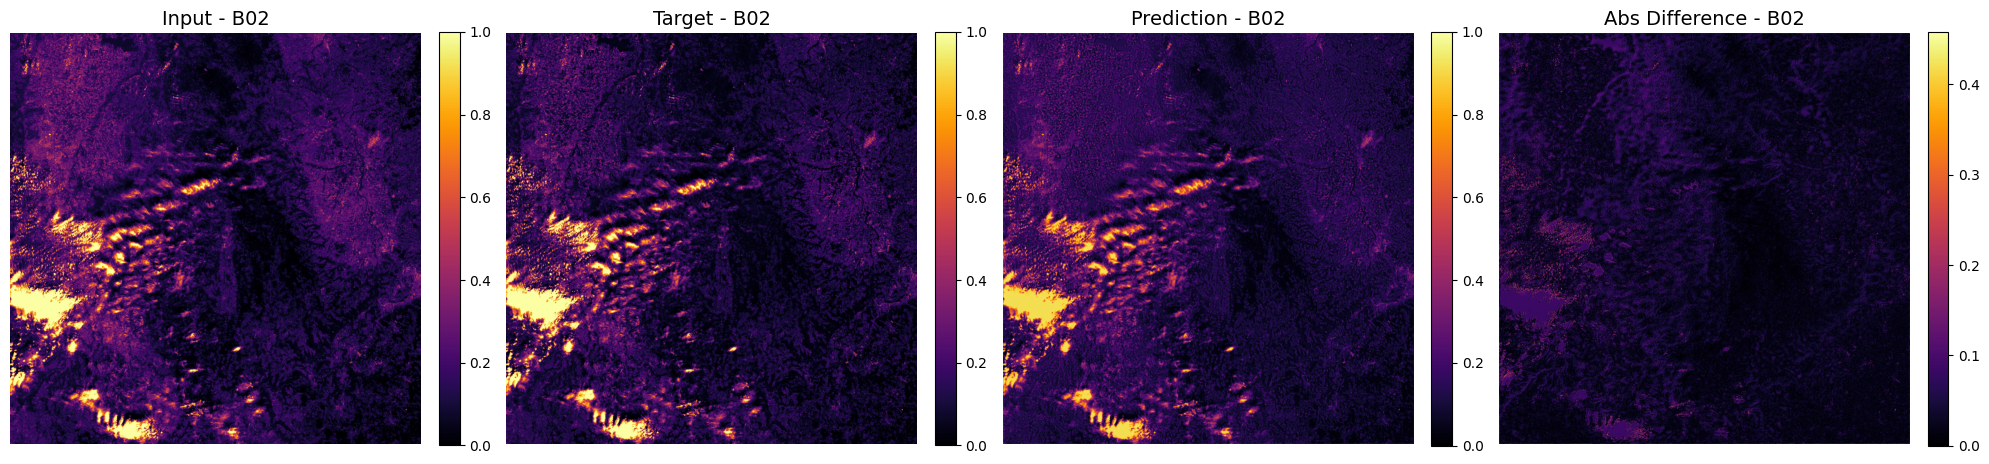

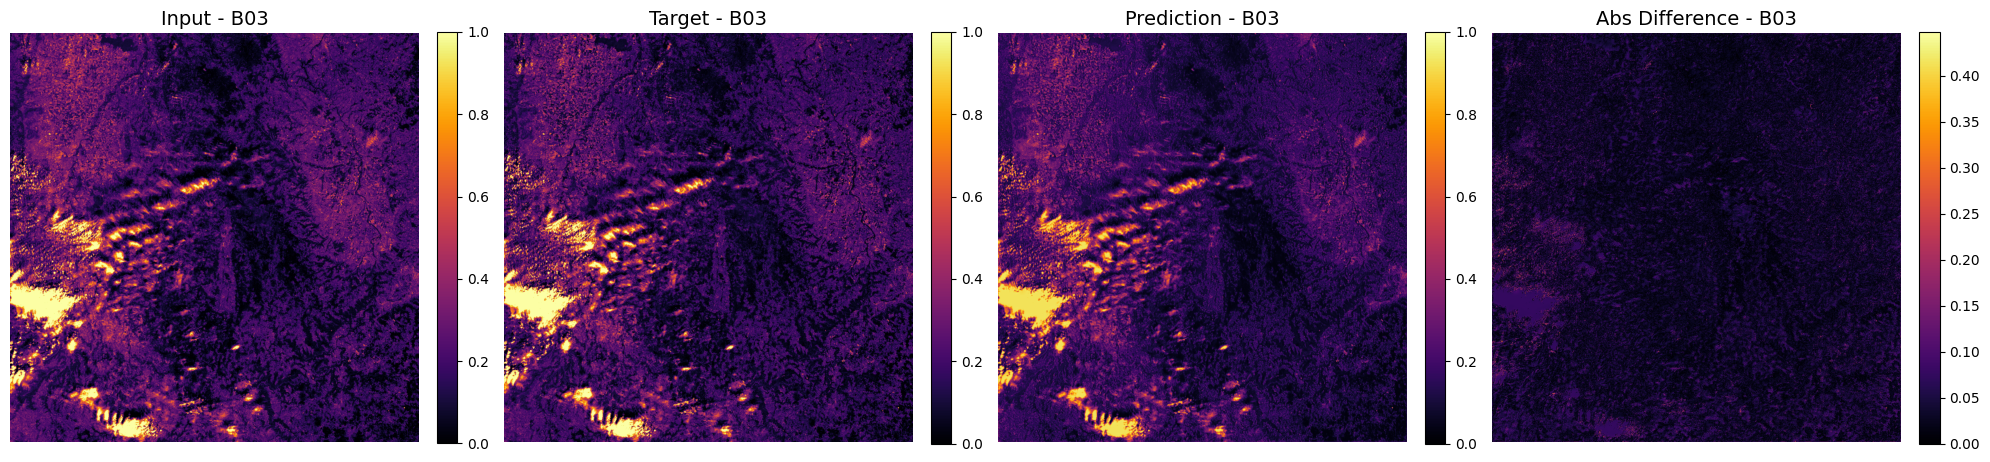

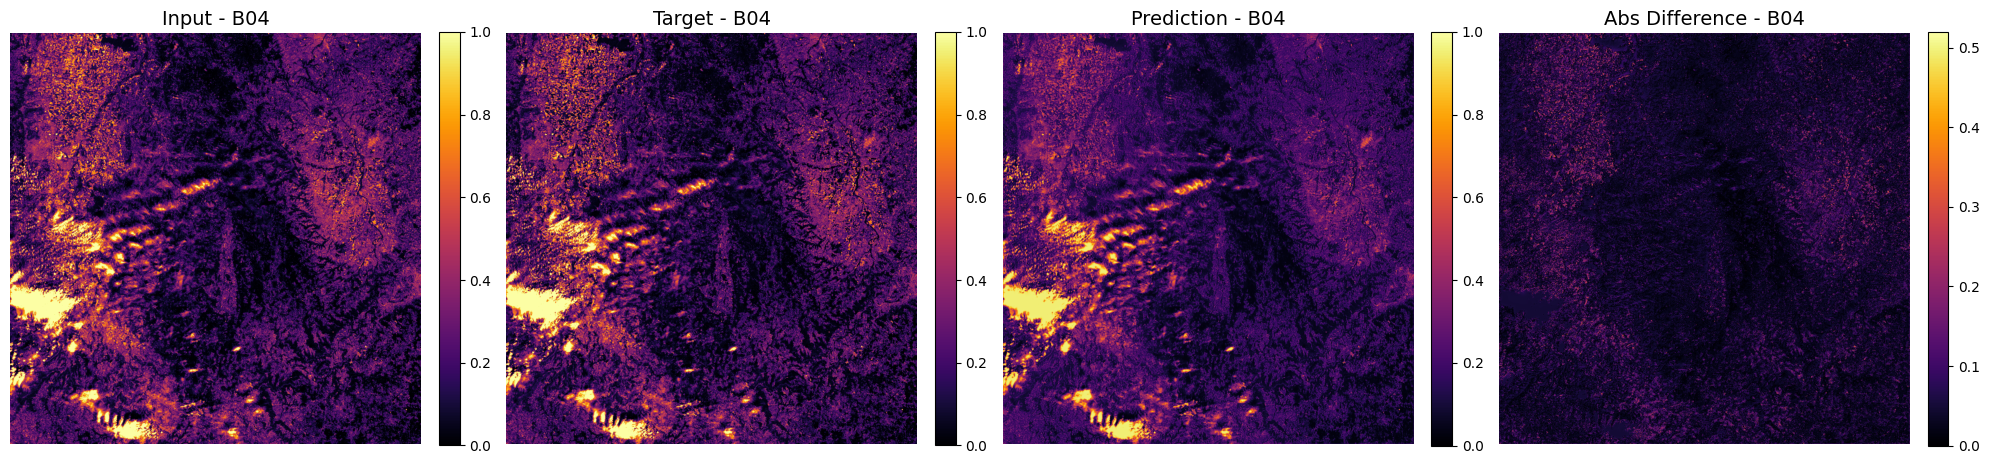

In [27]:
random_index = np.random.choice(df_test_input.index)
random_row = df_test_input.loc[random_index]

evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=random_index,cmap="inferno",  verbose=True, save=False, output_path=None)

## Plot SAM vs Cloud Coverage 

In [ ]:
# Visualization for SAM vs Cloud Cover
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))
cmap = plt.cm.plasma
global_ymax = max(df_test_output[f'sam_{band}'].max() for band in bands) * 1.05  # 5% buffer

for i, band in enumerate(bands):
    ax = axs[i]
    scatter = ax.scatter(data=df_test_output, x='cloud_cover', y=f'sam_{band}',
                        c=df_test_output['cloud_cover'], cmap=cmap)
    ax.set_title(f"{band} - Test Data", fontsize=14)
    ax.set_xlabel("Cloud Cover (%)", fontsize=12)
    ax.set_ylabel("SAM", fontsize=12)
    ax.set_ylim(0, global_ymax)
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()
plt.savefig(f"{exp_paths['metrics_path']}/sam_vs_cloud_cover.svg")
plt.show()
plt.close()

In [ ]:
# Visualization for SSIM vs Cloud Cover
fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))
global_ymin = min(df_test_output[f'ssim_{band}'].min() for band in bands) * 0.98  # 5% buffer

for i, band in enumerate(bands):
    ax = axs[i]
    scatter = ax.scatter(data=df_test_output, x='cloud_cover', y=f'ssim_{band}',
                        c=df_test_output['cloud_cover'], cmap=cmap)
    ax.set_title(f"{band} - Test Data", fontsize=14)
    ax.set_xlabel("Cloud Cover (%)", fontsize=12)
    ax.set_ylabel("SSIM", fontsize=12)
    ax.set_ylim(global_ymin, 1.0)
    plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

plt.tight_layout()
plt.savefig(f"{exp_paths['metrics_path']}/ssim_vs_cloud_cover.svg")
plt.show()
plt.close()

## Plot SAM vs % Valid Pixel

In [ ]:
# Visualization for SAM vs Valid Pixel
fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))
global_ymax = max(df_test_output[f'sam_{band}'].max() for band in bands) * 1.05

for i, band in enumerate(bands):
    ax = axs[i]
    scatter = ax.scatter(data=df_test_output, x='valid_pixel', y=f'sam_{band}',
                        c=df_test_output['valid_pixel'], cmap=cmap)
    ax.set_title(f"{band} - Test Data", fontsize=14)
    ax.set_xlabel("Valid Pixel (%)", fontsize=12)
    ax.set_ylabel(f"SAM {band}", fontsize=12)
    ax.set_ylim(0, global_ymax)
    plt.colorbar(scatter, ax=ax, label="Valid Pixel (%)")

plt.tight_layout()
plt.savefig(f"{exp_paths['metrics_path']}/sam_vs_valid_pixel.svg")
plt.show()
plt.close()

## Valid Pixel vs Cloud Cover vs SAM 

In [ ]:
plot_3d_scatter(
    df=df_test_output,
    x_col='cloud_cover',
    y_col='valid_pixel',
    z_col='sam_B02',
    color_col='cloud_cover',
    labels={
        'cloud_cover': 'Cloud Cover (%)',
        'valid_pixel': 'Valid Pixels (%)',
        'sam_B02': 'SAM B02'
    },
    title='3D Scatter: SAM B02 vs Cloud Cover vs Valid Pixels',
    output_path=f"{exp_paths['metrics_path']}/sam_vs_valid_pixel_cloud_cover.html"
)

## Identification top worst predictions for SAM and SSIM

In [ ]:
# Top worst predictions for SAM and SSIM
top_10_min_ssim_idx = df_test_output.sort_values(f'ssim_B02').head(10).index.tolist()
top_10_max_sam_idx = df_test_output.sort_values(f'sam_B02', ascending=False).head(10).index.tolist()

logger.info(f"Top 10 indices with minimum SSIM for B02: {top_10_min_ssim_idx}")
logger.info(f"Top 10 indices with maximum SAM for B02: {top_10_max_sam_idx}")

In [ ]:
# Evaluate and plot for worst SAM predictions
outputs_worst_sam_path = f"{exp_paths['metrics_path']}/outputs_worst_sam"
os.makedirs(outputs_worst_sam_path, exist_ok=True)

for idx in top_10_max_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize,
                    device=device, index=idx, verbose=False, save=True, output_path=outputs_worst_sam_path)

In [ ]:
# Evaluate and plot for worst SSIM predictions
outputs_worst_ssim_path = f"{exp_paths['metrics_path']}/outputs_worst_ssim"
os.makedirs(outputs_worst_ssim_path, exist_ok=True)

for idx in top_10_min_ssim_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize,
                    device=device, index=idx, verbose=False, save=True, output_path=outputs_worst_ssim_path)

## Identification to best predictions for SAM and SSIM

In [ ]:
# Top best predictions for SAM and SSIM
top_10_max_ssim_idx = df_test_output.sort_values(f'ssim_B02').tail(20).index.tolist()
top_10_min_sam_idx = df_test_output.sort_values(f'sam_B02', ascending=False).tail(20).index.tolist()

logger.info(f"Top 10 indices with maximum SSIM for B02: {top_10_max_ssim_idx}")
logger.info(f"Top 10 indices with minimum SAM for B02: {top_10_min_sam_idx}")

# Evaluate and plot for best SAM predictions
output_best_sam_path = f"{exp_paths['result_dir']}/outputs_best_sam"
os.makedirs(output_best_sam_path, exist_ok=True)

for idx in top_10_min_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize,
                    device=device, index=idx, verbose=False, save=True, output_path=output_best_sam_path)

# Evaluate and plot for best SSIM predictions
output_best_ssim_path = f"{exp_paths['result_dir']}/outputs_best_ssim"
os.makedirs(output_best_ssim_path, exist_ok=True)

for idx in top_10_max_ssim_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize,
                    device=device, index=idx, verbose=False, save=True, output_path=output_best_ssim_path)